Installs:

In [1]:
%pip install wavenet_vocoder

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install webrtcvad

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install audio_utils

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 KB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 5.3 MB/s eta 0:00:00a 0:00:01
Using legacy 'setup.py install' for ffmpy, since package 'wheel' is not installed.
  Running setup.py install for ffmpy ... done
Note: you may need to restart the kernel to use updated packages.


Imports:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
import numpy as np
import pandas as pd

import torch
from tqdm import tqdm
from wavenet_vocoder import builder

import random
import struct
from pathlib import Path
from typing import Optional, Union

import librosa
import webrtcvad
# from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage import binary_dilation

import soundfile as sf
from scipy import signal
from librosa.filters import mel
from numpy.random import RandomState
import pickle

from audio_utils import *


Functions for .wav to spectrogram and spectrogram to .wav

In [2]:
"""
Mel spectrogram to audio

from: https://www.kaggle.com/code/gaurav41/how-to-convert-audio-to-mel-spectrogram-to-audio/notebook

model weights: https://www.dropbox.com/s/zdbfprugbagfp2w/20180510_mixture_lj_checkpoint_step000320000_ema.pth?dl=0

"""

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


class DictWithDotNotation(dict):
    """
    a dictionary that supports dot notation
    as well as dictionary access notation
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct=None):
        dct = dict() if not dct else dct
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DictWithDotNotation(value)
            self[key] = value


class GetDictWithDotNotation(DictWithDotNotation):

    def __init__(self, hp_dict):
        super(DictWithDotNotation, self).__init__()

        hp_dotdict = DictWithDotNotation(hp_dict)
        for k, v in hp_dotdict.items():
            setattr(self, k, v)

    __getattr__ = DictWithDotNotation.__getitem__
    __setattr__ = DictWithDotNotation.__setitem__
    __delattr__ = DictWithDotNotation.__delitem__

PROJECT_DIR = ""
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Device type available = '{device}'")

hparam_dict = {
    # general parameters
    'general':{
        # small error
        'small_err': 1e-6,
        'is_training_mode': True,
        'device': device,
        'project_root': PROJECT_DIR,
    },
    # path to raw audio file
    "raw_audio": {
        "raw_audio_path": "static/raw_data/wavs",
        "train_spectrogram_path": "static/spectrograms/train",
        "test_spectrogram_path": "static/spectrograms/test",
        "train_percent": .8,
    },
    # audio --> same audio settings to be used in wavenet model to
    # reconstruct audio from mel-spectrogram
    "audio": {
        #"sampling_rate": 16000,
         "sampling_rate": 22050,
        # Number of spectrogram frames in a partial utterance
        "partials_n_frames": 180,  # 1600 ms

        "n_fft": 1024,  # 1024 seems to work well
        "hop_length": 1024 // 4,  # n_fft/4 seems to work better

        "mel_window_length": 25,  # In milliseconds
        "mel_window_step": 10,  # In milliseconds
        "mel_n_channels": 80,

    },
    ## Voice Activation Detection
    "vad": {
        # Window size of the VAD. Must be either 10, 20 or 30 milliseconds.
        # This sets the granularity of the VAD. Should not need to be changed.
        "vad_window_length": 30,  # In milliseconds
        # Number of frames to average together when performing the moving average smoothing.
        # The larger this value, the larger the VAD variations must be to not get smoothed out.
        "vad_moving_average_width": 8,
        # Maximum number of consecutive silent frames a segment can have.
        "vad_max_silence_length": 6,

        ## Audio volume normalization
        "audio_norm_target_dBFS": -30,
        "rate_partial_slices": 1.3,
        "min_coverage": 0.75,
    },
    "m_wave_net": {
        "gen": {
            "best_model_path": "static/model_chk_pts/wavenet_model/checkpoint_step001000000_ema.pth"
        },
        "hp": {
            # DO NOT CHANGE THESE HP
            'name': "wavenet_vocoder",

            # Convenient model builder
            'builder': "wavenet",

            # Input type:
            # 1. raw [-1, 1]
            # 2. mulaw [-1, 1]
            # 3. mulaw-quantize [0, mu]
            # If input_type is raw or mulaw, network assumes scalar input and
            # discretized mixture of logistic distributions output, otherwise one-hot
            # input and softmax output are assumed.
            # **NOTE**: if you change the one of the two parameters below, you need to
            # re-run preprocessing before training.
            'input_type': "raw",
            'quantize_channels': 65536,  # 65536 or 256

            # Audio: these 4 items to be same as used to create mel out of audio
            # commented back in sr, fft_size, hop_size, num_mels
            #'sample_rate': 16000,
             'sample_rate': 22050,
            'fft_size': 1024,
            # # shift can be specified by either hop_size or frame_shift_ms
            'hop_size': 256,
            'num_mels': 80,

            # this is only valid for mulaw is True
            'silence_threshold': 2,

            'fmin': 125,
            'fmax': 7600,
            'frame_shift_ms': None,
            'min_level_db': -100,
            'ref_level_db': 20,
            # whether to rescale waveform or not.
            # Let x is an input waveform, rescaled waveform y is given by:
            # y = x / np.abs(x).max() * rescaling_max
            'rescaling': True,
            'rescaling_max': 0.999,
            # mel-spectrogram is normalized to [0, 1] for each utterance and clipping may
            # happen depends on min_level_db and ref_level_db, causing clipping noise.
            # If False, assertion is added to ensure no clipping happens.o0
            'allow_clipping_in_normalization': True,

            # Mixture of logistic distributions:
            'log_scale_min': float(-32.23619130191664),

            # Model:
            # This should equal to `quantize_channels` if mu-law quantize enabled
            # otherwise num_mixture * 3 (pi, mean, log_scale)
            'out_channels': 10 * 3,
            'layers': 24,
            'stacks': 4,
            'residual_channels': 512,
            'gate_channels': 512,  # split into 2 gropus internally for gated activation
            'skip_out_channels': 256,
            'dropout': 1 - 0.95,
            'kernel_size': 3,
            # If True, apply weight normalization as same as DeepVoice3
            'weight_normalization': True,
            # Use legacy code or not. Default is True since we already provided a model
            # based on the legacy code that can generate high-quality audio.
            # Ref: https://github.com/r9y9/wavenet_vocoder/pull/73
            'legacy': True,

            # Local conditioning (set negative value to disable))
            'cin_channels': 80,
            # If True, use transposed convolutions to upsample conditional features,
            # otherwise repeat features to adjust time resolution
            'upsample_conditional_features': True,
            # should np.prod(upsample_scales) == hop_size
            'upsample_scales': [4, 4, 4, 4],
            # Freq axis kernel size for upsampling network
            'freq_axis_kernel_size': 3,

            # Global conditioning (set negative value to disable)
            # currently limited for speaker embedding
            # this should only be enabled for multi-speaker dataset
            'gin_channels': -1,  # i.e., speaker embedding dim
            'n_speakers': -1,

            # Data loader
            'pin_memory': True,
            'num_workers': 2,

            # train/test
            # test size can be specified as portion or num samples
            'test_size': 0.0441,  # 50 for CMU ARCTIC single speaker
            'test_num_samples': None,
            'random_state': 1234,

            # Loss

            # Training:
            'batch_size': 2,
            'adam_beta1': 0.9,
            'adam_beta2': 0.999,
            'adam_eps': 1e-8,
            'amsgrad': False,
            'initial_learning_rate': 1e-3,
            # see lrschedule.py for available lr_schedule
            'lr_schedule': "noam_learning_rate_decay",
            'lr_schedule_kwargs': {},  # {"anneal_rate": 0.5, "anneal_interval": 50000},
            'nepochs': 2000,
            'weight_decay': 0.0,
            'clip_thresh': -1,
            # max time steps can either be specified as sec or steps
            # if both are None, then full audio samples are used in a batch
            'max_time_sec': None,
            'max_time_steps': 8000,
            # Hold moving averaged parameters and use them for evaluation
            'exponential_moving_average': True,
            # averaged = decay * averaged + (1 - decay) * x
            'ema_decay': 0.9999,

            # Save
            # per-step intervals
            'checkpoint_interval': 10000,
            'train_eval_interval': 10000,
            # per-epoch interval
            'test_eval_epoch_interval': 5,
            'save_optimizer_state': True,

            # Eval:
        }
    }
}

# this hp will be used throughout the project
hp = GetDictWithDotNotation(hparam_dict)

# few calculated values from wavenet model
hp.m_wave_net.hp.sample_rate = hp.audio.sampling_rate
hp.m_wave_net.hp.fft_size = hp.audio.n_fft
hp.m_wave_net.hp.hop_size = hp.audio.hop_length
hp.m_wave_net.hp.num_mels = hp.audio.mel_n_channels

int16_max = (2 ** 15) - 1


def preprocess_wav(fpath_or_wav: Union[str, Path, np.ndarray], hp, source_sr: Optional[int] = None):
    """
    Applies preprocessing operations to a waveform either on disk or in memory such that
    The waveform will be resampled to match the data hyperparameters.

    :param fpath_or_wav: either a filepath to an audio file (many extensions are supported, not
    just .wav), either the waveform as a numpy array of floats.
    :param source_sr: if passing an audio waveform, the sampling rate of the waveform before
    preprocessing. After preprocessing, the waveform'speaker sampling rate will match the data
    hyperparameters. If passing a filepath, the sampling rate will be automatically detected and
    this argument will be ignored.
    """

    # Load the wav from disk if needed
    if isinstance(fpath_or_wav, str) or isinstance(fpath_or_wav, Path):
        wav, source_sr = librosa.load(str(fpath_or_wav), sr=None)
    else:
        wav = fpath_or_wav

    # Resample the wav
    if source_sr is not None:
        orig_sr = source_sr
        target_sr = hp.audio.sampling_rate
        wav = librosa.resample(wav, orig_sr=orig_sr, target_sr= hp.audio.sampling_rate)
        #wav = librosa.resample(wav)

    # Apply the preprocessing: normalize volume and shorten long silences
    wav = normalize_volume(wav, hp.vad.audio_norm_target_dBFS, increase_only=True)
    #wav = trim_long_silences(wav, hp)

    sf.write('preprocessed_audio.wav', wav, 22050, 'PCM_24')

    return wav


def trim_long_silences(wav, hp):
    """
    Ensures that segments without voice in the waveform remain no longer than a
    threshold determined by the VAD parameters in params.py.

    :param wav: the raw waveform as a numpy array of floats
    :return: the same waveform with silences trimmed away (length <= original wav length)
    """
    # Compute the voice detection window size
    samples_per_window = (hp.vad.vad_window_length * hp.audio.sampling_rate) // 1000

    # Trim the end of the audio to have a multiple of the window size
    wav = wav[:len(wav) - (len(wav) % samples_per_window)]

    # Convert the float waveform to 16-bit mono PCM
    pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))

    # Perform voice activation detection
    voice_flags = []
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        voice_flag = vad.is_speech(pcm_wave[window_start * 2:window_end * 2], sample_rate=hp.audio.sampling_rate)
        voice_flags.append(voice_flag)

    voice_flags = np.array(voice_flags)

    # Smooth the voice detection with a moving average
    def moving_average(array, width):
        array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
        ret = np.cumsum(array_padded, dtype=float)
        ret[width:] = ret[width:] - ret[:-width]
        return ret[width - 1:] / width

    audio_mask = moving_average(voice_flags, hp.vad.vad_moving_average_width)
    audio_mask = np.round(audio_mask).astype(np.bool_)

    # Dilate the voiced regions
    audio_mask = binary_dilation(audio_mask, np.ones(hp.vad.vad_max_silence_length + 1))
    audio_mask = np.repeat(audio_mask, samples_per_window)

    return wav[audio_mask == True]


def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    if increase_only and decrease_only:
        raise ValueError("Both increase only and decrease only are set")
    rms = np.sqrt(np.mean((wav * int16_max) ** 2))
    wave_dBFS = 20 * np.log10(rms / int16_max)
    dBFS_change = target_dBFS - wave_dBFS
    if dBFS_change < 0 and increase_only or dBFS_change > 0 and decrease_only:
        return wav
    return wav * (10 ** (dBFS_change / 20))


def compute_partial_slices(n_samples: int, hp):
    """
    Computes where to split an utterance waveform and its corresponding mel spectrogram to
    obtain partial utterances of <partials_n_frames> each. Both the waveform and the
    mel spectrogram slices are returned, so as to make each partial utterance waveform
    correspond to its spectrogram.

    The returned ranges may be indexing further than the length of the waveform. It is
    recommended that you pad the waveform with zeros up to wav_slices[-1].stop.

    :param n_samples: the number of samples in the waveform
    :param rate: how many partial utterances should occur per second. Partial utterances must
    cover the span of the entire utterance, thus the rate should not be lower than the inverse
    of the duration of a partial utterance. By default, partial utterances are 1.6s long and
    the minimum rate is thus 0.625.
    :param min_coverage: when reaching the last partial utterance, it may or may not have
    enough frames. If at least <min_pad_coverage> of <partials_n_frames> are present,
    then the last partial utterance will be considered by zero-padding the audio. Otherwise,
    it will be discarded. If there aren't enough frames for one partial utterance,
    this parameter is ignored so that the function always returns at least one slice.
    :return: the waveform slices and mel spectrogram slices as lists of array slices. Index
    respectively the waveform and the mel spectrogram with these slices to obtain the partial
    utterances.
    """
    assert 0 < hp.vad.min_coverage <= 1

    # Compute how many frames separate two partial utterances
    samples_per_frame = int((hp.audio.sampling_rate * hp.mel_fb.mel_window_step / 1000))
    n_frames = int(np.ceil((n_samples + 1) / samples_per_frame))
    frame_step = int(np.round((hp.audio.sampling_rate / hp.vad.rate_partial_slices) / samples_per_frame))

    min_frame_step = (hp.audio.sampling_rate / (samples_per_frame * hp.audio.partials_n_frames))
    assert 0 < frame_step, "The rate is too high"
    assert frame_step <= hp.audio.partials_n_frames, "The rate is too low, it should be %f at least" % min_frame_step

    # Compute the slices
    wav_slices, mel_slices = [], []
    steps = max(1, n_frames - hp.audio.partials_n_frames + frame_step + 1)
    for i in range(0, steps, frame_step):
        mel_range = np.array([i, i + hp.audio.partials_n_frames])
        wav_range = mel_range * samples_per_frame
        mel_slices.append(slice(*mel_range))
        wav_slices.append(slice(*wav_range))

    # Evaluate whether extra padding is warranted or not
    last_wav_range = wav_slices[-1]
    coverage = (n_samples - last_wav_range.start) / (last_wav_range.stop - last_wav_range.start)
    if coverage < hp.vad.min_coverage and len(mel_slices) > 1:
        mel_slices = mel_slices[:-1]
        wav_slices = wav_slices[:-1]

    return wav_slices, mel_slices

def pySTFT(x, fft_length=1024, hop_length=256):
    """
    this function returns spectrogram (short time fourier transform)
    :param x: np array for the audio file
    :param fft_length: fft length for fast fourier transform (https://www.youtube.com/watch?v=E8HeD-MUrjY)
    :param hop_length: hop_length is the sliding overlapping window size normally fft//4 works the best
    :return: spectrogram in the form of np array
    """
    x = np.pad(x, int(fft_length // 2), mode='reflect')

    noverlap = fft_length - hop_length
    shape = x.shape[:-1] + ((x.shape[-1] - noverlap) // hop_length, fft_length)
    strides = x.strides[:-1] + (hop_length * x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

    # window of given type and length
    fft_window = signal.get_window('hann', fft_length, fftbins=True)
    # compute 1-dim discrete Fourier transform for real input
    # result = np.fft.rfft(fft_window * result, n=fft_length).T

    result = librosa.core.stft(x, n_fft=1024, hop_length=hop_length)

    return np.abs(result)

def butter_highpass(cutoff, fs, order=5):
    """
    high pass Butterworth digital filter
    Params:
    - cutoff = cutoff freq of filter, frequencies below this value will be attenuated
    - fs = sampling frequency of signal
    """
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq    # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    # b, a = numerator, denominator polynomials of IIR filter (infinite impulse response)
    return b, a

def wav_to_mel_spectrogram(wav, hp):
    """
    Derives a mel spectrogram ready to be used by the encoder from a preprocessed audio waveform.
    Note: this not a log-mel spectrogram.
    """

    # creating mel basis matrix: linear transform matrix
    # to project FFT bins onto Mel-frequency bins
    mel_basis = mel(sr=hp.audio.sampling_rate,  # sampling rate of signal
                    n_fft=hp.audio.n_fft,       # num FFT components
                    fmin=90,                    # lowest frequency (Hz) def: 90
                    fmax=7600,                  # highest frequency (Hz) def: 7600
                    n_mels=hp.audio.mel_n_channels).T   # num Mel bands to generate

    min_level = np.exp(-100 / 20 * np.log(10))

    # getting audio as a np array
    pp_wav = preprocess_wav(wav, hp, source_sr=22500)

    # Compute spectrogram
    spectrogram = pySTFT(pp_wav).T
    # Convert to mel and normalize
    mel_spect = np.dot(spectrogram, mel_basis)
    d_db = 20 * np.log10(np.maximum(min_level, mel_spect)) - 16
    norm_mel_spect = np.clip((d_db + 100) / 100, 0, 1)

    return norm_mel_spect

def shuffle_along_axis(a, axis):
    """
    :param a: nd array e.g. [40, 180, 80]
    :param axis: array axis. e.g. 0
    :return: a shuffled np array along the given axis
    """
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


### Build Wavenet model - used to convert mel-spectrogram to audio
torch.set_num_threads(4)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = 'cpu'

hparams = hp.m_wave_net.hp

def build_model():
    """Build Wavenet model"""
    model = getattr(builder, hparams.builder)(
    out_channels=hparams.out_channels,
    layers=hparams.layers,
    stacks=hparams.stacks,
    residual_channels=hparams.residual_channels,
    gate_channels=hparams.gate_channels,
    skip_out_channels=hparams.skip_out_channels,
    cin_channels=hparams.cin_channels,
    gin_channels=hparams.gin_channels,
    weight_normalization=hparams.weight_normalization,
    n_speakers=hparams.n_speakers,
    dropout=hparams.dropout,
    kernel_size=hparams.kernel_size,
    upsample_conditional_features=hparams.upsample_conditional_features,
    upsample_scales=hparams.upsample_scales,
    freq_axis_kernel_size=hparams.freq_axis_kernel_size,
    scalar_input=True,
    legacy=hparams.legacy,
    )
    return model

def wavegen(model, c=None, tqdm=tqdm):
    """
    Generate waveform samples by WaveNet.
    """

    model.eval()
    model.make_generation_fast_()

    Tc = c.shape[0]
    upsample_factor = hparams.hop_size
    # Overwrite length according to feature size
    length = Tc * upsample_factor

    # B x C x T
    c = torch.FloatTensor(c.T).unsqueeze(0)

    initial_input = torch.zeros(1, 1, 1).fill_(0.0)

    # Transform data to GPU
    initial_input = initial_input.to(device)
    c = None if c is None else c.to(device)

    with torch.no_grad():
        y_hat = model.incremental_forward(
            initial_input, c=c, g=None, T=length, tqdm=tqdm, softmax=True, quantize=True,
            log_scale_min=hparams.log_scale_min)

    y_hat = y_hat.view(-1).cpu().data.numpy()

    return y_hat

Device type available = 'cpu'


In [17]:
from PIL import Image

c = "20180510_mixture_lj_checkpoint_step000320000_ema.pth"
checkpoint = torch.load(c, map_location=device)
model = build_model().to(device)
model.load_state_dict(checkpoint["state_dict"])

spect_content = wav_to_mel_spectrogram('content/content.wav', hp)
spect_style = wav_to_mel_spectrogram('content/style.wav', hp)

##
spect_content = spect_content[:512,:]
spect_content.shape
spect_style = spect_style[:512,:]
spect_style.shape
##


spect_content_gray = np.dot(spect_content,255)
spect_style_gray = np.dot(spect_style, 255)

img_content = Image.fromarray(spect_content_gray).convert('RGB')
img_style = Image.fromarray(spect_style_gray).convert('RGB')

img_content.save('content/content_img.png')
img_style.save('content/style_img.png')


/mnt/c/users/amrut/onedrive/desktop/Deep Learning/Project/Audio-Style-Transfer/venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
from pytorch_pretrained_vit import ViT
vision_transformer = ViT('B_16_imagenet1k', pretrained=True)




Loaded pretrained weights.


In [5]:
import pytorch_pretrained_vit as V

In [21]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [30]:


def gram_matrix(input):
    """Compute gram matrix"""
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())  # inner product of
    return G.div(a * b * c * d)           # divide by layer dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# desired size of the output image
#imsize = (128,128)
imsize = (128,80)


loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])     # transform it into a torch tensor


def image_loader(image_name):
    """Load image to visualize"""
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def imshow(tensor, title=None):
    """Show images"""
    image = tensor.cpu().clone()    # we clone the tensor to not do changes on it
    image = image.squeeze(0)        # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

class ContentLoss(nn.Module):
    """Class representing content loss"""
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        """Forward pass"""
        # print("Input shape:", input.shape)
        # print("Target shape:", self.target.shape)
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    """Class representing style loss"""
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        """Forward pass"""
        G = gram_matrix(input)
        # print("Input shape:", input.shape)
        # print("Target shape:", self.target.shape)
        self.loss = F.mse_loss(G, self.target)
        return input

vision_transformer.to(device)


# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_style_model_and_losses(vision_transformer, normalization_mean, normalization_std,
                               style_img, content_img, content_layers, style_layers):
    """
    Choose intermediate layers from the network to represent the style
    and content of the image; use the selected intermediate layers
    to get the content and style representations of the image.
    """
    vision_transformer = copy.deepcopy(vision_transformer)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    img_model = nn.Sequential(normalization)
    # just in order to have an iterable access to or list of content/syle losses

    content_losses = []
    style_losses = []
    # print(content_img.shape)
    # print(style_img.shape)
    content_features = img_model(content_img).detach()
    style_features = img_model(style_img).detach()
    i = 0  # increment every time we see a conv
    for name, layer in vision_transformer.named_children():
        if name == 'transformer':
            for module_name, module_layer in layer.named_children():
                if module_name == 'blocks':
                    for block_name, block_layer in module_layer.named_children():
                        if isinstance(block_layer, V.transformer.Block):
                            i += 1
                            newname = 'Block_{}'.format(i)
                        else:
                            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

                        img_model.add_module(newname, block_layer)
                        # print(newname)
                        if newname in content_layers:
                            target = content_features
                            content_loss = ContentLoss(target)
                            img_model.add_module("content_loss_{}".format(i), content_loss)
                            content_losses.append(content_loss)
                        if newname in style_layers:
                            target_feature = style_features
                            style_loss = StyleLoss(target_feature)
                            img_model.add_module("style_loss_{}".format(i), style_loss)
                            style_losses.append(style_loss)
                            

    # now we trim off the layers after the last content and style losses
    for i in range(len(img_model) - 1, -1, -1):
        if isinstance(img_model[i], ContentLoss) or isinstance(img_model[i], StyleLoss):
            break
    img_model = img_model[:(i + 1)]
    return img_model, style_losses, content_losses

style_layers_selected = ['Block_1', 'Block_2']
content_layers_selected = ['Block_11', 'Block_12']

def run_style_transfer(vision_transformer, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=0.05, content_weight=0.001,
                       content_layers=content_layers_selected,
                       style_layers=style_layers_selected):
    """Run the style transfer."""
    print('Building the style transfer model...')
    vision_transformer, style_losses, content_losses = get_style_model_and_losses(vision_transformer,
        normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1, eps=1e-1)


    print('Optimizing...')
    output_img = input_img.clone()
    output_img = output_img.reshape(1, 1, 40, 768)
    # output_img = output_img.unsqueeze(0)
    step_i = 0
    while step_i <= num_steps:
        output_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        for i, layer in enumerate(vision_transformer):
            if isinstance(layer, V.transformer.Block):
                # print(i, layer, output_img.shape)
                output_img = output_img.reshape(1, 1, 40, 768) #had to calculate this 
                output_img = layer(output_img, mask=None)
            else:
                output_img = output_img.reshape(1, 3, 128, 80)
                output_img = layer(output_img)
    # this whole loop was off the dome 
            

        # compute losses
        style_score = torch.tensor(0.0, requires_grad=True)
        content_score = torch.tensor(0.0, requires_grad=True)
        for style_loss in style_losses:
            style_score = style_score + style_loss.loss.detach()
        for content_loss in content_losses:
            content_score = content_score + content_loss.loss.detach()

        loss = style_score*style_weight + content_score*content_weight
        loss.backward()

        optimizer.step()

        step_i += 1
        if step_i % 50 == 0:
            print("run {}:".format(step_i))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

    # a last correction...
    output_img.data.clamp_(0, 1)

    return output_img

Building the style transfer model...
Optimizing...


/tmp/ipykernel_655253/3535202648.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_655253/3535202648.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run 50:
Style Loss : 1.526954 Content Loss: 452.443481

run 100:
Style Loss : 1.718498 Content Loss: 262.542908



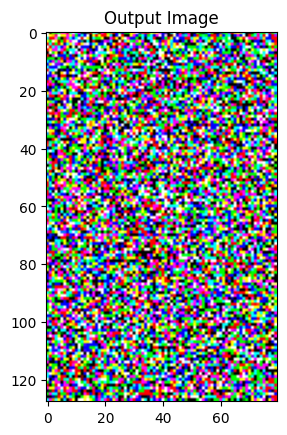

In [31]:
#Test model, need to define content + style image
style_img = image_loader('content/style_img.png') 
content_img = image_loader('content/content_img.png') 

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

#style_weight=100000
# style_weight=1.5
# print(content_img.shape)
# print(style_img.shape)
#both are [1, 3, 128, 80]
input_img = content_img.clone().detach().requires_grad_(True)
img_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
img_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
output = run_style_transfer(vision_transformer, img_normalization_mean, img_normalization_std, content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

# Added code #

output = output.detach().cpu()

# Convert to a NumPy array
#output = output.numpy()
output = np.array(output, dtype=np.float32)
output = output[0, 0, :, :]
output = np.dot(output,255)
output = Image.fromarray(output).convert("L")
output.save('output.png')


In [25]:
# Display the image

output = Image.open('output.png')
# image_array = np.array(output, dtype=np.float32)
#spect_reconstructed = np.dot(image_array, 1/255)
spect_reconstructed = np.dot(output, 1/255)


librosa.display.specshow(spect_reconstructed, sr=hparams.sample_rate, x_axis='time',
                         y_axis='hz', hop_length=hparams.hop_size, cmap='magma')

waveform = wavegen(model, spect_reconstructed)

sf.write('reconstructed_audio_test.wav', waveform, 22050, 'PCM_24')


100%|██████████| 32768/32768 [03:33<00:00, 153.38it/s]
